# Fishery Data Exploration
The purpose of this competition on [Kaggle](https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring) is to develop a model that classifies species of fish within a collection of images.  This notebook exhibits a brief exploration of the dataset and preprocesses the data for model development later.  Images are stored in the working directory folder 'data', sub-divided by train and test set.  The training set are also sub-divided by species, while the test_stg1 set are mixed and not separated by species folders.

#### Dependencies

In [1]:
import numpy as np
from scipy import ndimage, misc
import os
import matplotlib.pyplot as plt
%matplotlib inline
from six.moves import cPickle as pickle



## Questions
### Are the images of similar aspect and pixel sizes?

In [2]:
print(os.listdir('data'))
print(os.listdir('data/train'))
print(os.listdir('data/train/ALB')[0:10])

['.DS_Store', 'test_stg1', 'test_stg1.zip', 'train', 'train.zip']
['.DS_Store', 'ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
['img_00003.jpg', 'img_00010.jpg', 'img_00012.jpg', 'img_00015.jpg', 'img_00019.jpg', 'img_00020.jpg', 'img_00029.jpg', 'img_00032.jpg', 'img_00037.jpg', 'img_00038.jpg']


In [3]:
for fish in os.listdir('data/train')[1:] :
    for image in os.listdir('data/train/'+fish)[0:3] :
        arr = ndimage.imread('data/train/'+fish+'/'+image, flatten = False)
        print("Shape: {}      Aspect Ratio: {:.2f}".format(arr.shape, arr.shape[1]/arr.shape[0]))

Shape: (720, 1280, 3)      Aspect Ratio: 1.78
Shape: (720, 1280, 3)      Aspect Ratio: 1.78
Shape: (974, 1280, 3)      Aspect Ratio: 1.31
Shape: (854, 1518, 3)      Aspect Ratio: 1.78
Shape: (720, 1280, 3)      Aspect Ratio: 1.78
Shape: (720, 1280, 3)      Aspect Ratio: 1.78
Shape: (720, 1280, 3)      Aspect Ratio: 1.78
Shape: (720, 1280, 3)      Aspect Ratio: 1.78
Shape: (750, 1280, 3)      Aspect Ratio: 1.71
Shape: (720, 1280, 3)      Aspect Ratio: 1.78
Shape: (720, 1280, 3)      Aspect Ratio: 1.78
Shape: (720, 1280, 3)      Aspect Ratio: 1.78
Shape: (720, 1280, 3)      Aspect Ratio: 1.78
Shape: (720, 1280, 3)      Aspect Ratio: 1.78
Shape: (720, 1280, 3)      Aspect Ratio: 1.78
Shape: (720, 1280, 3)      Aspect Ratio: 1.78
Shape: (750, 1280, 3)      Aspect Ratio: 1.71
Shape: (720, 1280, 3)      Aspect Ratio: 1.78
Shape: (720, 1280, 3)      Aspect Ratio: 1.78
Shape: (720, 1280, 3)      Aspect Ratio: 1.78
Shape: (720, 1280, 3)      Aspect Ratio: 1.78
Shape: (974, 1280, 3)      Aspect 

**Answer:** Images appear to be of different pixel sizes and aspect ratios, and are RGB format.  

### How many of each fish species are present in the training set?

In [4]:
count = 0
for fish in os.listdir('/'.join(['data','train'])) :
    try : 
        print("{} contains {} images".format(fish, len(os.listdir('/'.join(['data','train',fish])))))
        count += len(os.listdir('/'.join(['data','train',fish])))
    #print(fish)
    except :
        pass
print("\nTOTAL TRAINING IMAGES: {}".format(count))                      

ALB contains 1719 images
BET contains 200 images
DOL contains 117 images
LAG contains 67 images
NoF contains 465 images
OTHER contains 299 images
SHARK contains 176 images
YFT contains 734 images

TOTAL TRAINING IMAGES: 3777


**Answer:** The counts of each fish are not equal in the training set.  Special precautions will be taken to avoid problems associated with unbalanced data sets.  3777 is not a vast amount for neural network training.  One potential strategy is to duplicate images with distortion in order to balance the dataset and provide extra training examples.  

## Experiment with image distortion techniques

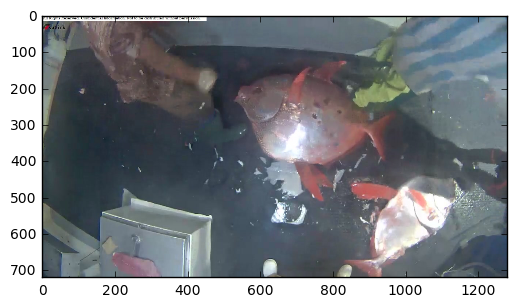

In [5]:
test_img = ndimage.imread('data/train/LAG/'+os.listdir('data/train/LAG')[0])
plt.imshow(test_img)
plt.show()

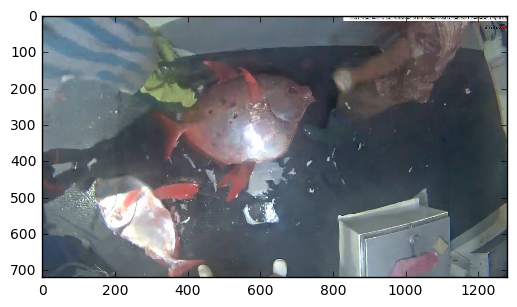

In [6]:
mod_test_img = np.fliplr(test_img)
plt.imshow(mod_test_img)
plt.show()

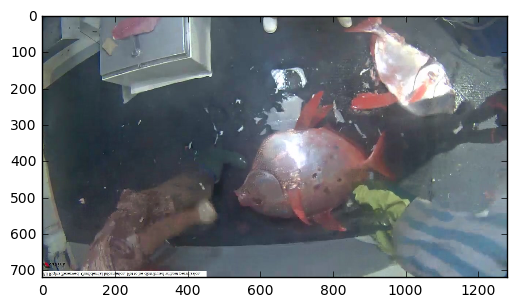

In [7]:
mod_test_img = np.flipud(test_img)
plt.imshow(mod_test_img)
plt.show()

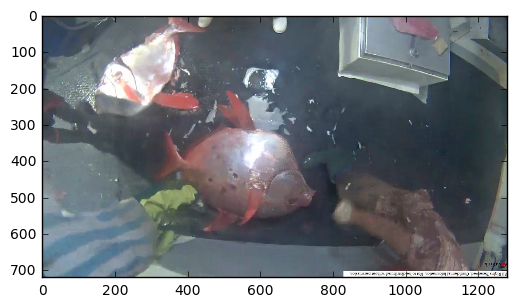

In [8]:
mod_test_img = np.flipud(np.fliplr(test_img))
plt.imshow(mod_test_img)
plt.show()

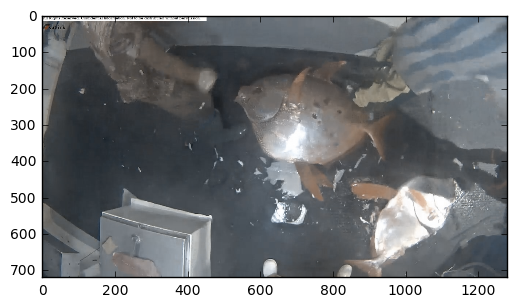

In [9]:
mod_test_img = ndimage.filters.gaussian_filter1d(test_img, 1, axis=-1, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0)
plt.imshow(mod_test_img)
plt.show()

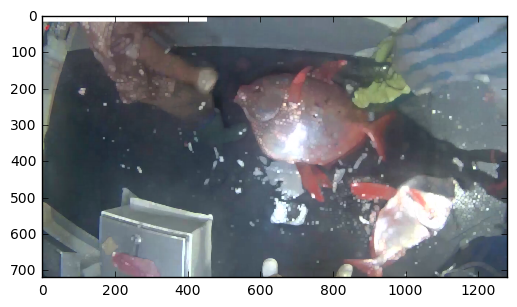

In [10]:
mod_test_img = ndimage.maximum_filter(test_img, size=(5,5,1), footprint=None, output=None, mode='reflect', cval=0.0, origin=0)
plt.imshow(mod_test_img)
plt.show()

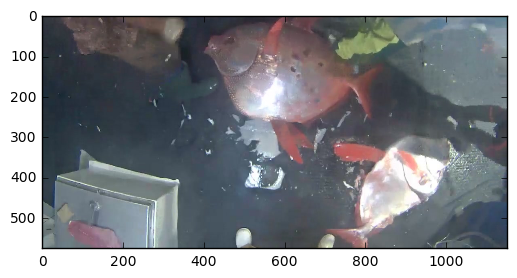

In [11]:
mod_test_img = test_img[test_img.shape[0]//5:, test_img.shape[1]//10:, :]
plt.imshow(mod_test_img)
plt.show()

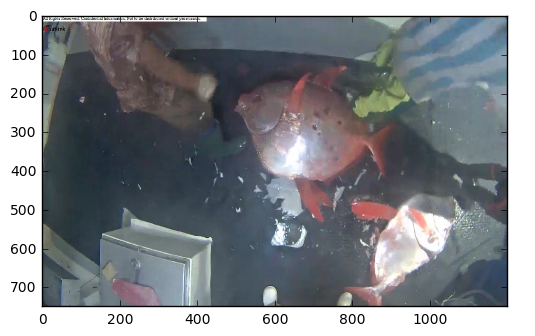

In [12]:
mod_test_img = misc.imresize(test_img, (750,1200,3))
plt.imshow(mod_test_img)
plt.show()

### Design a function to mutate images randomly

In [13]:
def mutate_image(image) :
    "Receives an image and returns an image with a random set of distortions"
    assert len(image.shape) == 3 , 'Image is not in 3D'
    assert image.shape[2] == 3, 'Image is not in RGB format'
    
    flip_hor, flip_ver, sigma, vert_off, hor_off, top, left = [np.random.randint(0,2), 
                                                    np.random.randint(0,2), 
                                                    np.random.choice([0, np.sqrt(np.random.random())]), 
                                                    np.random.randint(5,15), 
                                                    np.random.randint(10,20),
                                                    np.random.randint(0,2),
                                                    np.random.randint(0,2)]
    #shift the image
    if top > 0 :
        if left > 0 :
            image_prime = test_img[image.shape[0]//vert_off:, test_img.shape[1]//hor_off:, :]
        else :
            image_prime = test_img[image.shape[0]//vert_off:, :-test_img.shape[1]//hor_off, :]
    else :
        if left > 0 :
            image_prime = test_img[:-image.shape[0]//vert_off, test_img.shape[1]//hor_off:, :]
        else :
            image_prime = test_img[:-image.shape[0]//vert_off, :-test_img.shape[1]//hor_off, :]
    
    if flip_hor > 0 : 
        image_prime = np.fliplr(image_prime)

    if flip_ver > 0 :
        image_prime = np.flipud(image_prime)
    return(ndimage.filters.gaussian_filter(image_prime, sigma))
    

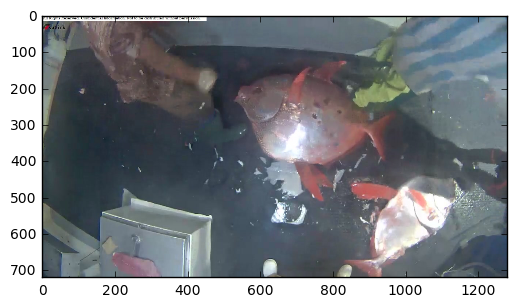

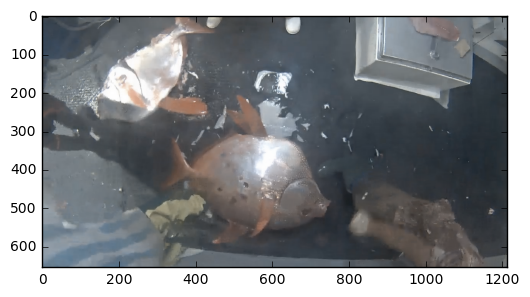

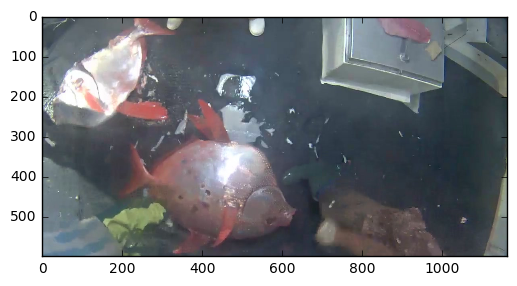

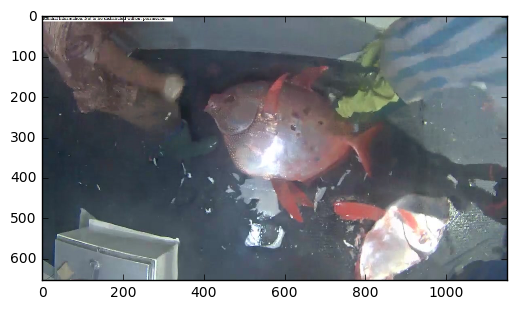

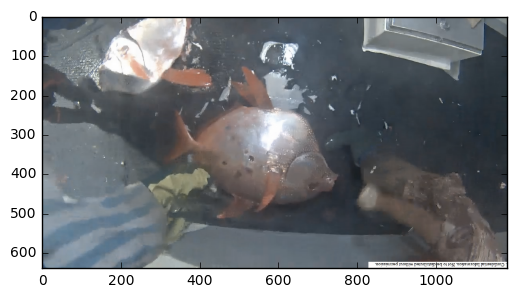

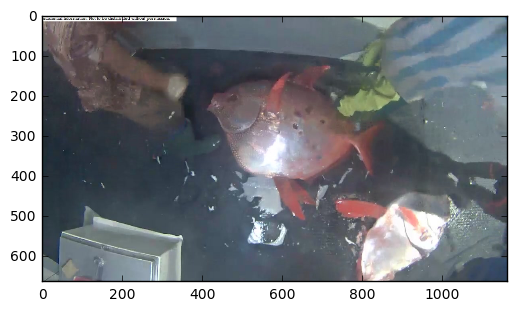

In [14]:
plt.imshow(test_img)
plt.show()
image = test_img
for i in range(5) :
    image_p = mutate_image(image)
    plt.imshow(image_p)
    plt.show()
    

## Preprocessing

My original plan was to pad each image set with a set of derivative images generated from the `mutate_image` function such that the image sets sizes for each fish were equivalent.  While one option would have been to simply duplicate the images as needed to generate dataset balance, this could have resulted in significant overfitting, as a model may simply learn specific images and not the patterns within, especially for the fish image sets that contained a small number of images to start.  THus by applying mutation to the original images in order to pad the image sets as needed, one can more efficiently re-use each image in a different context.  By flipping, rotating, distorting the color, and making slight shifts in offset, scale, and aspect ratio, hopefully a trained model will learn the important characteristics of the fish species instead of overfitting to specific images.

The problem with this approach is the fileset size.  Because the images are quite large, it is not ideal to bring each set, including mutated derivatives, into the kernel memory.  Cursory attempts for even one fish set have crashed my system.  

Thus instead of mutating and pre-processing each image into one large set to begin the project, I will let the model work with data outside the kernel memory.  Each training step will initiate by randomly selecting images to go into the training batch, with each image randomly mutated, scaled, normalized, and stacked into a standard sized array.  By applying mutation to each image each time it is randomly selected, a finite set of images is turned into an infinite training set.  The parameters for mutation can be made more aggressive or more conservative based on model training speed, etc.  

To accomplish this strategy, I will need to engineer a way to draw equivalent counts for each fish into each training batch, and will generate a function for this task below.  

In [15]:
os.listdir('data/train')[1:]

['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

In [16]:
def generate_epoch_set_list_and_label_array(min_each) :
    """Function to generate a list of filenames for each training epoch.  Some files 
    will be used multiple times in order that each fish is drawn into a training batch
    an equivalent number of times."""
    # Count the images in each set and append to a fish_list
    for i, species_ID in enumerate(os.listdir('data/train')[1:]) :
        fish_file_names = []
        fish_file_names = ['data/train/'+species_ID+'/'+x for x in os.listdir('data/train/'+species_ID) ]
        fish_count = len(fish_file_names)
        assert min_each > fish_count, 'Listed minimum number of images is exceeded by the actual number of images.  Increase minimum number to generate a balanced dataset'
        
        multiples = min_each // fish_count
        remainder = min_each % fish_count
        fish_file_names = (fish_file_names* multiples) + np.random.choice(fish_file_names, remainder).tolist()
        print("'{}' set contains {} filenames from which to sample".format(species_ID, len(fish_file_names)))
        
        #make one-hot label array 
        fish_label_arr = np.zeros([min_each, len(os.listdir('data/train')[1:])])
        fish_label_arr[:, i] = 1
        
        try : 
            master_file_names = master_file_names + fish_file_names
            master_label_arr = np.concatenate([master_label_arr,fish_label_arr], 0)
        except :
            master_file_names = fish_file_names
            master_label_arr = fish_label_arr
    return master_file_names, master_label_arr

In [17]:
min_each = 2000
X, y = generate_epoch_set_list_and_label_array(min_each)

'ALB' set contains 2000 filenames from which to sample
'BET' set contains 2000 filenames from which to sample
'DOL' set contains 2000 filenames from which to sample
'LAG' set contains 2000 filenames from which to sample
'NoF' set contains 2000 filenames from which to sample
'OTHER' set contains 2000 filenames from which to sample
'SHARK' set contains 2000 filenames from which to sample
'YFT' set contains 2000 filenames from which to sample


In [18]:
print("{} filenames in the master epoch set list".format(len(X)))
print("Shape of label_array: {}".format(y.shape))

16000 filenames in the master epoch set list
Shape of label_array: (16000, 8)


In [19]:
print("Each row contains a single '1' label: {}".format(np.all(np.sum(y,1) == 
                                                               np.ones(min_each*8))))
print("Each column contains 'min_each' x '1' labels: {}".format(np.all(np.sum(y,0)==[min_each]*8)))

Each row contains a single '1' label: True
Each column contains 'min_each' x '1' labels: True


**NOTE:** Helper functions will be stored in a module called 'fish_data' in the local directory to be retrieved in the actual model build.  